# Exploratory Data Analysis

### Objective and Hypotheses:

#### To analyze the price relations between certain cryptocurrencies and the equities market over a 32 months period and to determine possible correlations.

#### Hypothesis (1): Price of cryptocurrencies (BTC and ETH) strongly correlate, but do not correlate with the broader equities market (SPY).

#### Hypothesis (2): Price of blockchain related stocks correlates better with BTC than with the prices of other stocks.

In [2]:
# Don't modify this cell.
# Dependencies and Setup
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

#import statistics
import requests
import time
#import math
#from scipy import stats
from pprint import pprint

# Import API key
from api_keys import api_key

#import ready packages
from alpha_vantage.timeseries import TimeSeries
from alpha_vantage.cryptocurrencies import CryptoCurrencies

#### The above code imports all packages we might need¶ 

In [3]:
#Using existing alpha_vantage packages:

def get_crypto(sym, mar): # function takes the symbol of the crypto and the market (US) as parameters
    ccb = CryptoCurrencies(key=api_key, output_format='pandas')
    data, meta_data = ccb.get_digital_currency_daily(symbol=sym, market=mar)
    data = data.drop(columns = ['1a. open (USD)', '1b. open (USD)', '2a. high (USD)', '2b. high (USD)',
       '3a. low (USD)', '3b. low (USD)', '4a. close (USD)',
       '5. volume', '6. market cap (USD)']) # we drop all columns we do not need, keep only the close price
    data = data.rename(columns = {'4b. close (USD)' : f'{sym} (USD)'}) # rename column appropriately
    return data, meta_data

b_data, b_meta_data = get_crypto('BTC', 'USD') # request and load data using our function
e_data, e_meta_data = get_crypto('ETH', 'USD')

crypto_data = pd.concat([b_data, e_data], axis = 1) # put both into the same dataframe for ease of use
crypto_data.head(1)

,BTC (USD),ETH (USD)
date,,
2021-11-11,64535.8,4592.74


#### Here we defined a function that requests and loads the crypto data we will need

In [4]:
def plot_correlations(df, roll, location1, location2, delta, fsize, lsize):
    columns = df.columns.to_list()
# this function takes multiple parameters, the dataframe to work with, the rolling period for the rolling correlation,
# the (x coordinate) location of the line representing the global correlation, the (x coordinate) location of the anno-
# tation, their difference (delta) in y coordinates and title fontsize as well as tick labelsize.
    
    fig = plt.figure(figsize = (22, 18)) # create figure
    
    ax0 = fig.add_subplot(3, 1, 1) # create 3 subplots in a column
    ax2 = fig.add_subplot(3, 1, 2)
    ax3 = fig.add_subplot(3, 1, 3, sharex = ax2) #
    
    fig.tight_layout(pad = 7.0) # set the spacing between plots
    
    ax0.scatter(df[columns[0]], df[columns[1]], c = df.index, cmap = 'viridis') # create scatterplot using the 2 columns of df, set color hue by index (which is the date)
    ax0.set_xlabel(f'Price of {columns[0]}', color = 'r', fontsize = fsize) # set labels with appropriate color and size
    ax0.set_ylabel(f'Price of {columns[1]}', color = 'b', fontsize = fsize)
    ax0.set_title(f'Scatterplot of {columns[0]} and {columns[1]} Prices, Hues Representing Time, Lighter more Recent', fontsize = fsize)
    ax0.tick_params('x', colors = 'r', labelbottom = True, labelsize = lsize) # set the tick parameters
    ax0.tick_params('y', colors = 'b', labelsize = lsize)
    
    ax2.plot(df.index, df[columns[0]], c = 'r') # plot time series of one asset
    ax2.set_xlabel('Date', fontsize = fsize)
    ax2.set_ylabel(f'Price of {columns[0]}', color = 'r', fontsize = fsize)
    ax2.set_title(f'Time Series of {columns[0]} and {columns[1]} Prices', fontsize = fsize)
    ax2.tick_params('y', colors = 'r', labelsize = lsize)
    ax2.tick_params('x', labelbottom = True, labelsize = lsize)

    ax4 = ax2.twinx() # share axes with ax2 and plot on the same space (y axes labels will be different)
    ax4.plot(df.index, df[columns[1]], c = 'b') # plot time series of other asset
    ax4.set_ylabel(f'Price of {columns[1]}', color = 'b', fontsize = fsize)
    ax4.tick_params('y', colors = 'b', labelbottom = True, labelsize = lsize)
    
    ax3.plot(df[columns[0]].rolling(window = roll).corr(df[columns[1]]).shift(periods = -(roll-1))) # plot rolling correlation coefficient, presented at the end of each (roll) day period
    ax3.axhline(df.corr().iloc[0,1], c = 'r') # draw a red line showing the global correlation coefficient
    ax3.tick_params('y', labelsize = lsize)
    ax3.tick_params('x', labelsize = lsize)
    ax3.set_xlabel('Date', fontsize = fsize)
    ax3.set_ylabel('45 day rolling correlation between' '\n' f'{columns[0]} and {columns[1]} prices', fontsize = fsize)
    ax3.set_title(f'Rolling Correlation Analysis of {columns[0]} and {columns[1]} Prices', fontsize = fsize)
    ax3.annotate(f'global correlation coefficient: {round(df.corr().iloc[0,1], 3)}', 
               xy = [pd.Timestamp(location1), df.corr().iloc[0,1]], xytext = [pd.Timestamp(location2), df.corr().iloc[0,1] - delta], arrowprops = {}, fontsize = 20) # set location and arrowtype of annotation
    
    fig.savefig(f'Analysis of {columns[0]} and {columns[1]} Prices.png') # save figure
    print(df.corr())
    

### Comparing BTC and ETH Prices

           BTC (USD)  ETH (USD)
BTC (USD)    1.00000    0.92276
ETH (USD)    0.92276    1.00000


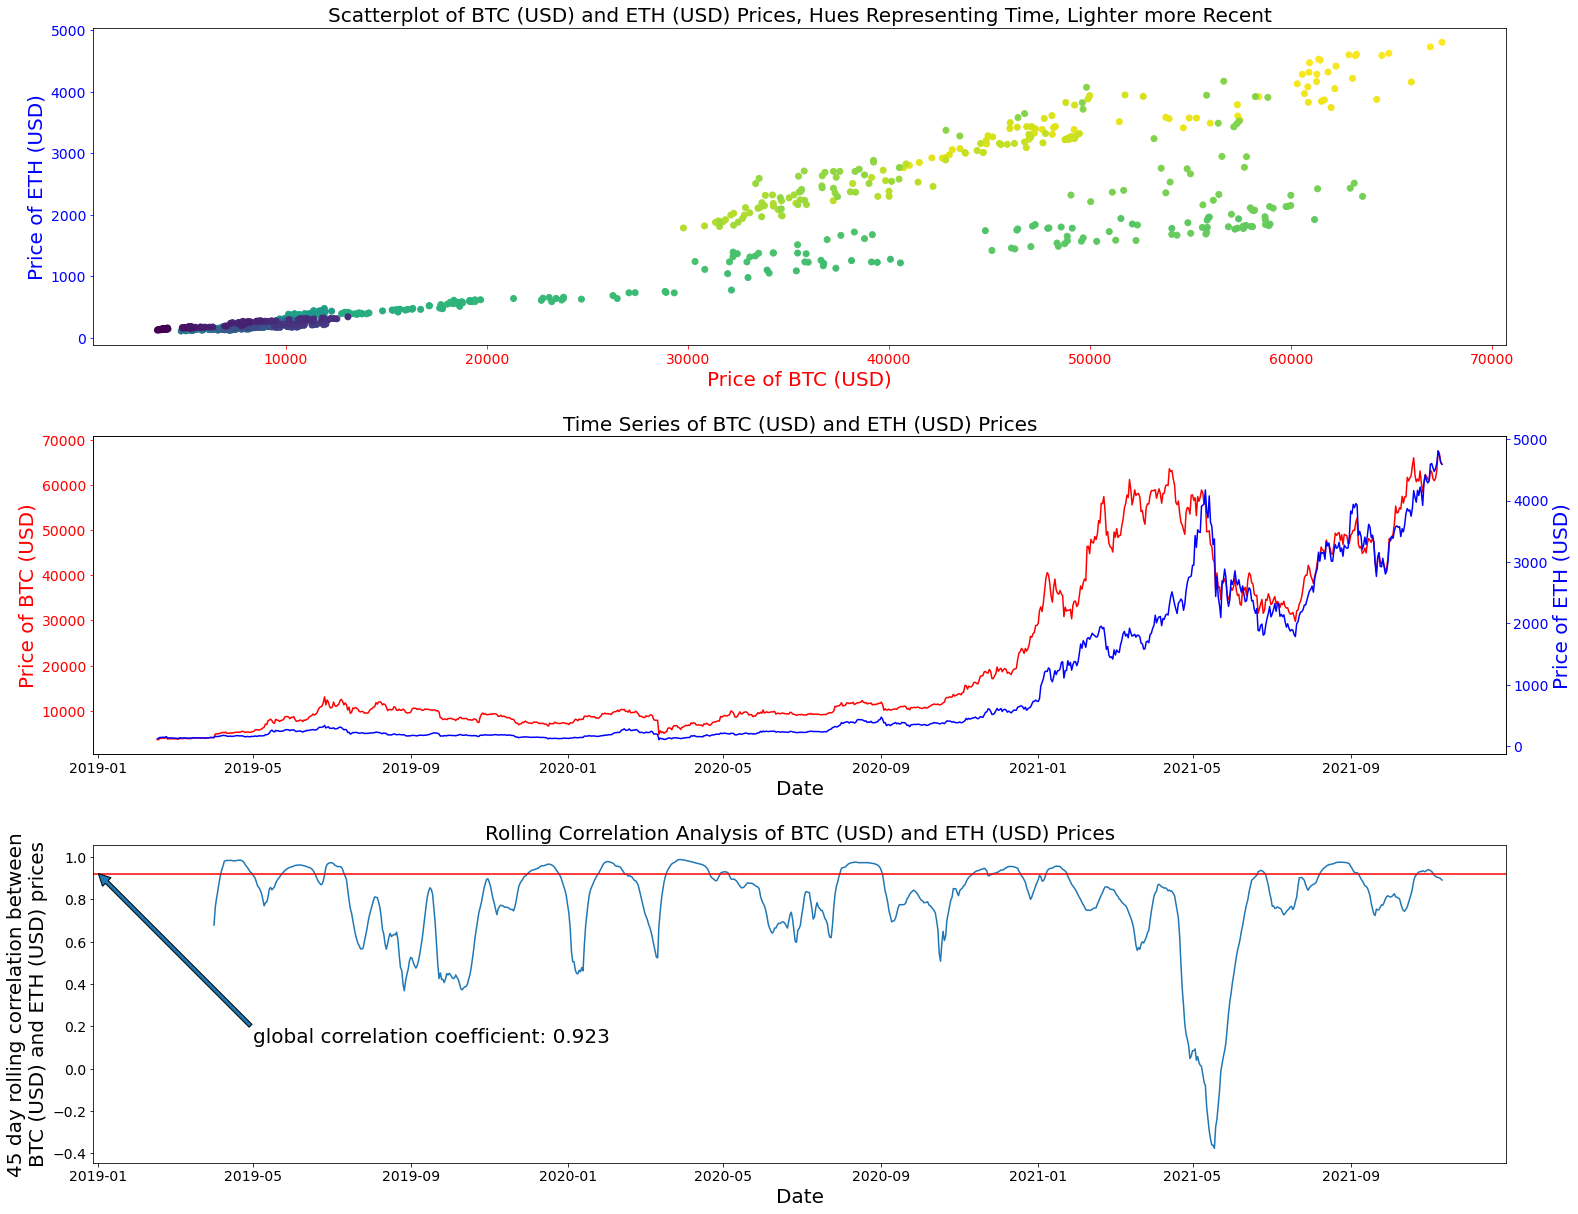

In [5]:
plot_correlations(crypto_data, 45, '2019-01', '2019-05', 0.8, 20, 14)

### Correlation between BTC and ETH prices

<Figure size 360x288 with 0 Axes>

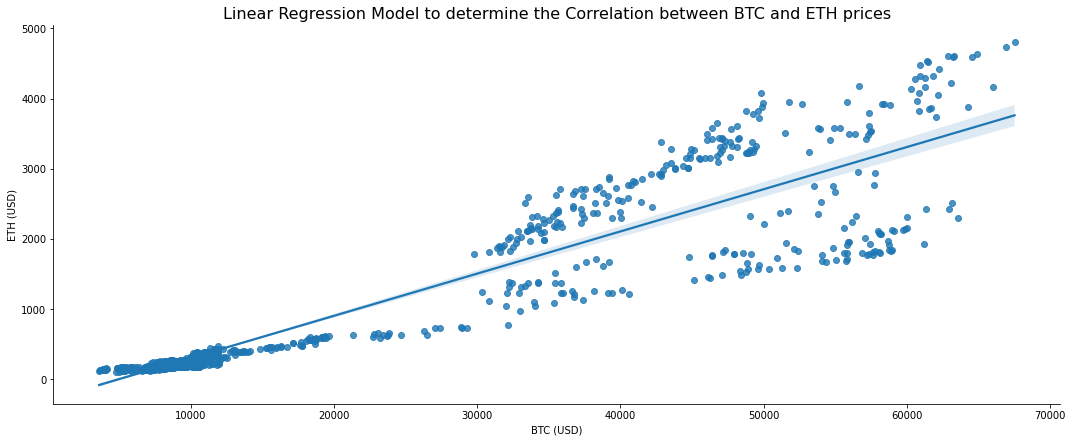

In [9]:
plt.figure(figsize=(5, 4))
sns.lmplot(x="BTC (USD)", y="ETH (USD)", data=crypto_data, height=6, aspect=2.5)
plt.title("Linear Regression Model to determine the Correlation between BTC and ETH prices", fontsize=16)
plt.show()

#### Here we define a function that requests and loads stock price data

In [10]:
def get_stock(sym): # takes in one parameter: the symbol of the stock

    ts = TimeSeries(key= api_key, output_format='pandas')
    data, meta_data = ts.get_daily(symbol=sym, outputsize='full')
    data = data.drop(columns = ['1. open', '2. high', '3. low', '5. volume']) # we drop unecessary columns
    data = data.rename(columns = {'4. close': f'{sym} (USD)'}) # we rename the remaining column
    return data, meta_data

spy_data, spy_meta_data = get_stock('SPY') # get data for SPY

spy_btc_data = b_data.join(spy_data, how = 'inner')
spy_btc_data.tail(1)

,BTC (USD),SPY (USD)
date,,
2019-02-19,3907.79,277.85


### Comparing BTC and SPY Prices

           BTC (USD)  SPY (USD)
BTC (USD)   1.000000   0.896008
SPY (USD)   0.896008   1.000000


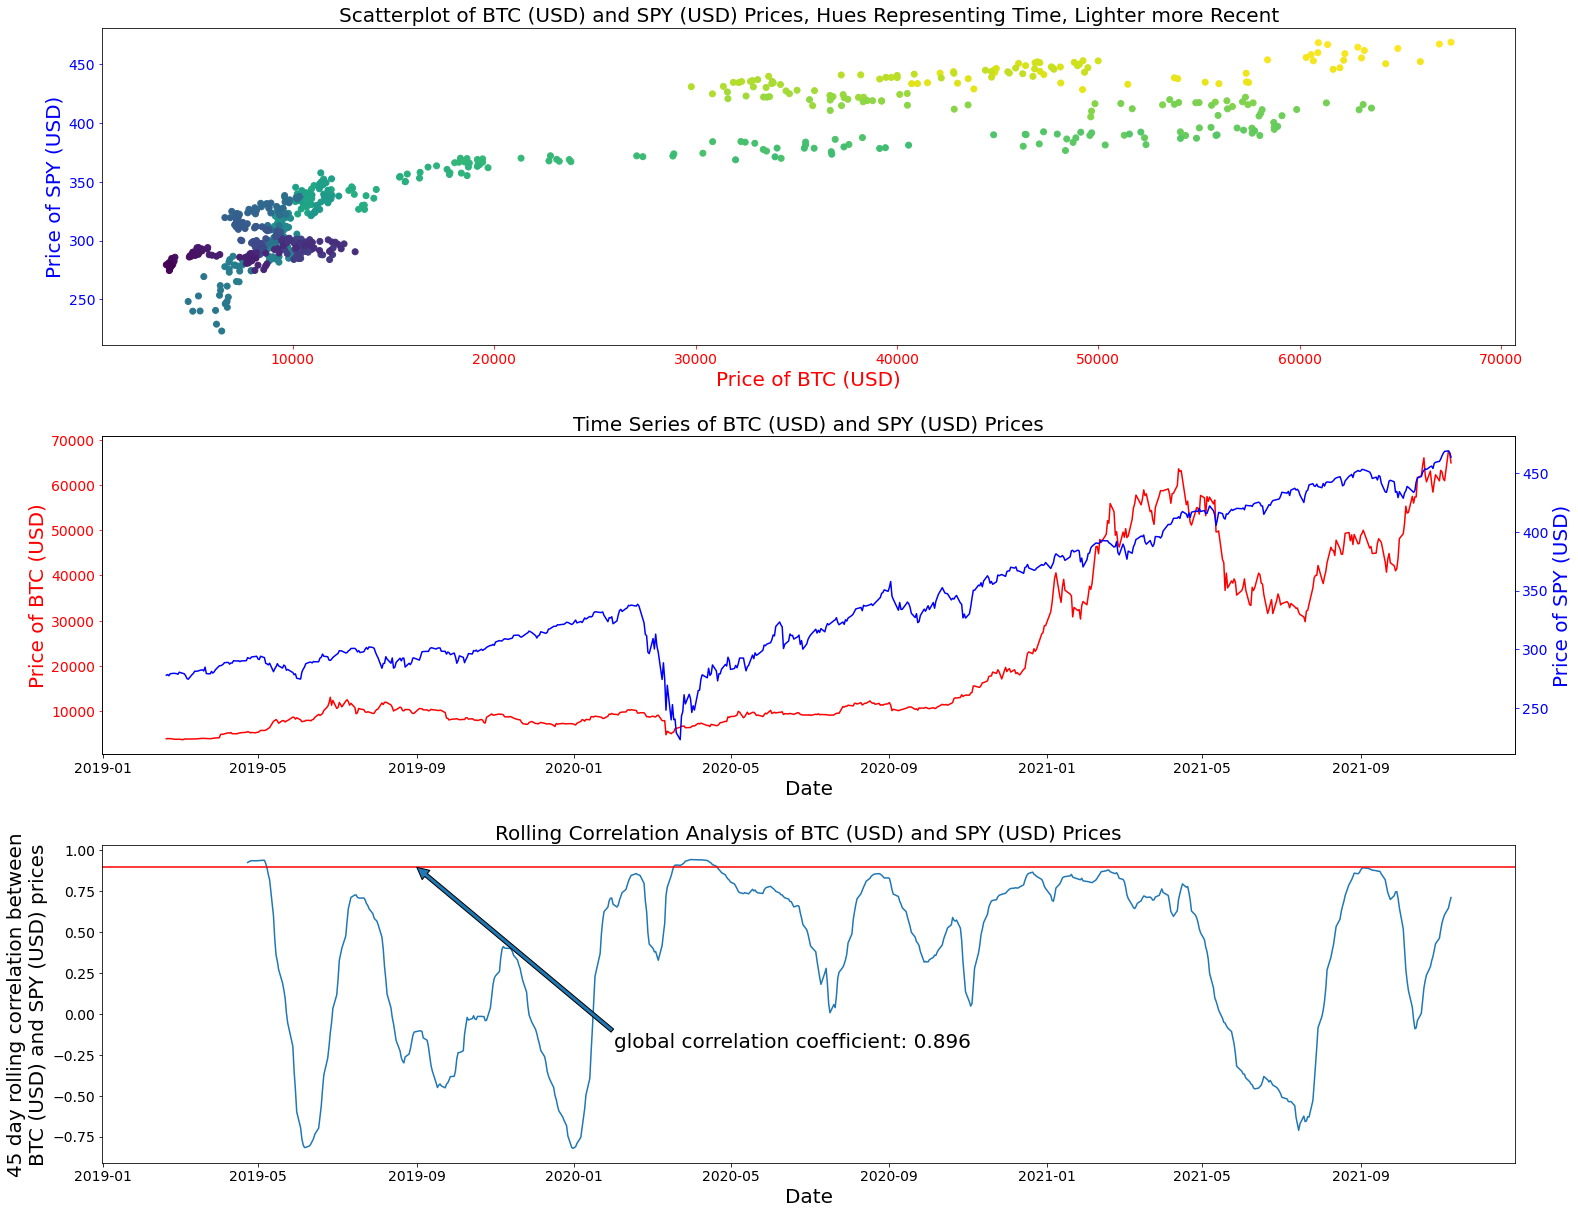

In [11]:
plot_correlations(spy_btc_data, 45, '2019-09', '2020-02', 1.1, 20, 14)

### Comparing BTC and HIVE Prices

In [12]:
hive_data, hive_meta_data = get_stock('HIVE')

hive_btc_data = b_data.join(hive_data, how = 'inner')
hive_btc_data.tail(1)

,BTC (USD),HIVE (USD)
date,,
2019-02-19,3907.79,0.3582


            BTC (USD)  HIVE (USD)
BTC (USD)    1.000000    0.973535
HIVE (USD)   0.973535    1.000000


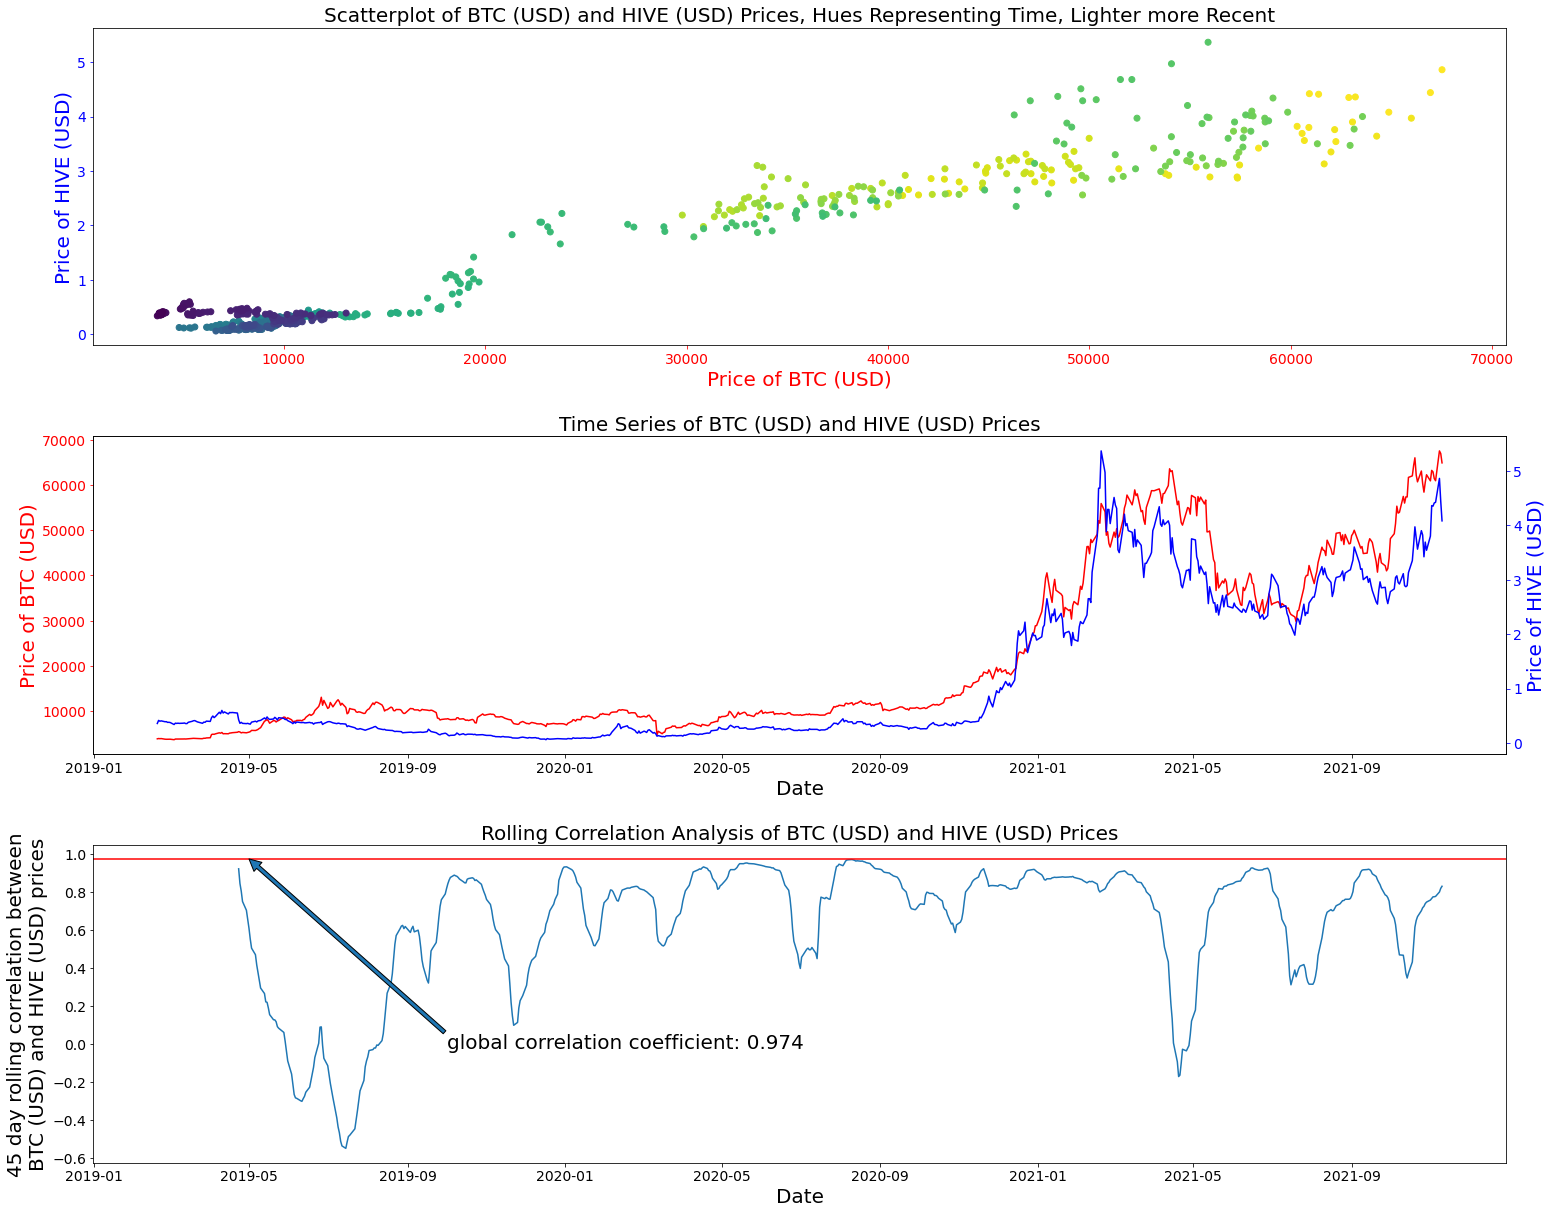

In [13]:
plot_correlations(hive_btc_data, 45, '2019-05', '2019-10', 1, 20, 14)

### Correlation between ETC and HIVE prices

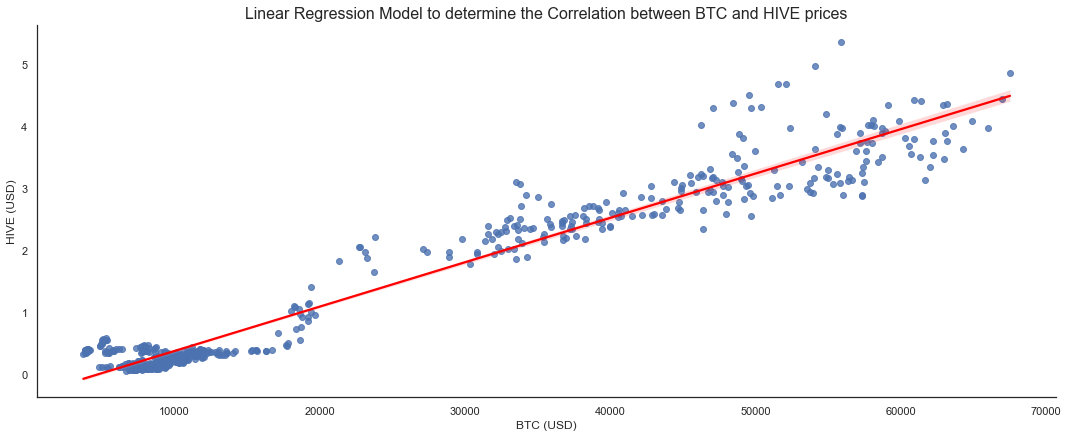

In [14]:
import seaborn as sns
sns.set(style="white", color_codes=True)
sns.lmplot(x="BTC (USD)", y="HIVE (USD)", data=hive_btc_data, height=6, aspect=2.5, line_kws={'color': 'red'})
plt.title("Linear Regression Model to determine the Correlation between BTC and HIVE prices", fontsize=16);